In [1]:
from datasets import Dataset, DatasetDict
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
from transformers import TrainingArguments, Trainer

2024-12-29 16:57:29.681279: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-29 16:57:29.700793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735487849.722075 2011067 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735487849.728487 2011067 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-29 16:57:29.738331: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
base_model_checkpoint = 'bert-base-cased'
model_name = 'bert-finetuned-cadec'
root_txt = 'CADEC.v2/cadec/text/'
root_ann = 'CADEC.v2/cadec/original/'

In [3]:
label_names = ['O', 'B-ADR', 'I-ADR', 'B-Drug', 'I-Drug', 'B-Finding', 
               'I-Finding', 'B-Disease', 'I-Disease', 'B-Symptom', 'I-Symptom']
id2label = {i: l for i, l in enumerate(label_names)}
label2id = {l: i for i, l in id2label.items()}

# Data pre-processing

## Functions

In [4]:
def read_files(fn):
    med, i = re.findall(r'(\w+)\.(\d+)\.txt', fn)[0]
    i = int(i)

    with open(os.path.join(root_txt, fn), 'r') as infile:
        text = infile.readlines()
        text = ''.join(text)
    with open(os.path.join(root_ann, fn.replace('txt', 'ann')), 'r') as infile:
        annotations = infile.readlines()
        annotations = [l.strip() for l in annotations if not l.startswith('#')]
    return i, med, text, annotations
    

def parse_annotations(lines):
    annots = {}
    for i in range(len(lines)):
        annots[i] = {}
        entity = re.findall(r'(Finding|ADR|Drug|Disease|Symptom) ([\d; ]+)\t(.*)$', 
                            lines[i])[0]
        annots[i]['ner'] = entity[0]
        boundaries = entity[1].split(';')
        boundaries = [[int(bb) for bb in b.split()] for b in boundaries]
        annots[i]['boundaries'] = boundaries
        annots[i]['text'] = entity[2]
    return annots


def get_current_annot(annots, idx, start):
    if idx >= len(annots):
        return idx - 1
    boundaries = annots[idx]['boundaries']
    if start > boundaries[-1][-1]:
        return get_current_annot(annots, idx+1, start)
    return idx


def print_tags_tokens(data):
    tokens = data['tokens']
    tags = data['ner']
    line1 = ""
    line2 = ""
    for word, label in zip(tokens, tags):
        max_length = max(len(word), len(label))
        line1 += word + " " * (max_length - len(word) + 1)
        line2 += label + " " * (max_length - len(label) + 1)
    print(line1)
    print(line2)


def get_IOB_tags(text: str, annotations: dict, map_tags_to_int=False):
    tokens = re.findall(r'\w+|[^\w\s]', text)
    if len(annotations) == 0:
        return tokens, [0 for _ in tokens]
    offset = 0
    idx = 0
    tags = []
    text_tmp = text
    for token in tokens:
        span = np.asarray(re.search(re.escape(token), text_tmp).span())
        idx = get_current_annot(annotations, idx, span[0] + offset)
        boundaries = annotations[idx]['boundaries']
        found = False
        for i, (start, end) in enumerate(boundaries):
            if (span[0] + offset >= start) and (span[1] + offset <= end):
                prefix = 'B-'
                if i > 0 or span[0] + offset > start:
                    prefix = 'I-'
                tags.append(prefix + annotations[idx]['ner'])
                found = True
                break
        if not found:
            tags.append('O')
        offset += span[1]
        text_tmp = text_tmp[span[1]:]
    if map_tags_to_int:
        tags = [label2id[tag] for tag in tags]
    return tokens, tags


def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['tokens'], truncation=True, is_split_into_words=True
    )
    all_labels = examples['ner']
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    
    tokenized_inputs['labels'] = new_labels
    return tokenized_inputs



def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

## Parsing data into the desired format

In [5]:
data = {}

for fn in os.listdir(root_txt):
    i, med, text, annotations = read_files(fn)
    annots = parse_annotations(annotations)
    tokens, tags = get_IOB_tags(text, annots, map_tags_to_int=True)
    if med not in data.keys():
        data[med] = {}
    data[med][i] = {
        'tokens': tokens, 'ner': tags
    }
    

## Creating datasets

In [6]:
raw_data = {}
idx = 0
train_pct = 0.64
val_pct = 0.16
test_pct = 0.2
for v in data.values():
    for vv in v.values():
        raw_data[idx] = vv
        idx += 1

indices = np.arange(len(raw_data))
np.random.shuffle(indices)
train_idx = indices[:int(train_pct * len(indices))]
val_idx = indices[int(train_pct * len(indices)):int((train_pct+val_pct) * len(indices))]
test_idx = indices[-int(test_pct * len(indices)):]

data_split = {'train': {}, 'val': {}, 'test': {}}
for split, indices in zip(('train', 'val', 'test'), (train_idx, val_idx, test_idx)):
    for idx in indices:
        for k in raw_data[idx].keys():
            if k not in data_split[split]:
                data_split[split][k] = []
            data_split[split][k].append(raw_data[idx][k])

datasets = {k: Dataset.from_dict(data_split[k]) for k in data_split.keys()}
datasets = DatasetDict(datasets)


### Dataset visualisations

In [7]:
ner = datasets['train']['ner']
ner = [tag for sentence in ner for tag in sentence]
tags, counts = np.unique(ner, return_counts=True)
df_tags = pd.DataFrame(index=tags, data=counts, columns=['counts'])

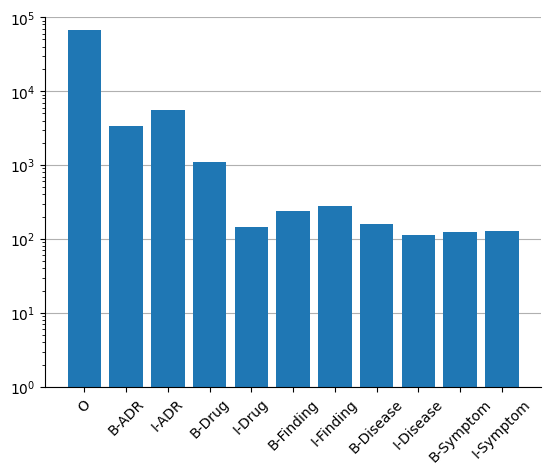

In [8]:
fig, ax = plt.subplots()
ax.bar(label_names, 
       df_tags.loc[[label2id[l] for l in label_names]].counts.values, 
       zorder=2)
ax.set_yscale('log')
ax.grid(axis='y', zorder=1)
ax.set_ylim(1, 1e5)
plt.xticks(rotation=45)
sns.despine()
plt.show()

# Fine-tuning for NER

In [9]:
tokenizer = AutoTokenizer.from_pretrained(base_model_checkpoint)

data_tokenized = datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=datasets['train'].column_names)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [12]:
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = evaluate.load('seqeval')

model = AutoModelForTokenClassification.from_pretrained(
    base_model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

args = TrainingArguments(
    model_name,
    #eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=data_tokenized["train"],
    eval_dataset=data_tokenized["val"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
   # processing_class=tokenizer,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
trainer.train()
#trainer.push_to_hub(commit_message="Training complete") 

Step,Training Loss


TrainOutput(global_step=300, training_loss=0.3383953603108724, metrics={'train_runtime': 120.9859, 'train_samples_per_second': 19.837, 'train_steps_per_second': 2.48, 'total_flos': 316260131342592.0, 'train_loss': 0.3383953603108724, 'epoch': 3.0})

In [14]:
# Get evaluation metrics on validation set
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

# Evaluate on test set
test_results = trainer.evaluate(data_tokenized["test"])
print("Test Set Results:", test_results)

Evaluation Results: {'eval_loss': 0.23928624391555786, 'eval_precision': 0.5348837209302325, 'eval_recall': 0.6561561561561562, 'eval_f1': 0.5893459204315575, 'eval_accuracy': 0.9201207064879737, 'eval_runtime': 2.3823, 'eval_samples_per_second': 83.953, 'eval_steps_per_second': 10.494, 'epoch': 3.0}


/vol/home/s4422090/miniconda3/envs/IDL/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Results: {'eval_loss': 0.2532006502151489, 'eval_precision': 0.5195797516714422, 'eval_recall': 0.6503287507471608, 'eval_f1': 0.5776479957525882, 'eval_accuracy': 0.9138388211996107, 'eval_runtime': 2.258, 'eval_samples_per_second': 110.717, 'eval_steps_per_second': 14.172, 'epoch': 3.0}


In [15]:
from seqeval.metrics import classification_report

def get_predictions(trainer, dataset):
    predictions = trainer.predict(dataset)
    logits = predictions.predictions
    labels = predictions.label_ids
    
    # Convert logits to predictions
    predictions = np.argmax(logits, axis=-1)
    
    # Convert to labels, removing special tokens (-100)
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    return true_predictions, true_labels

# Get detailed classification report
predictions, labels = get_predictions(trainer, data_tokenized["test"])
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

         ADR       0.48      0.66      0.56      1167
     Disease       0.02      0.03      0.02        40
        Drug       0.87      0.93      0.90       330
     Finding       0.11      0.09      0.10        98
     Symptom       0.00      0.00      0.00        38

   micro avg       0.52      0.65      0.58      1673
   macro avg       0.30      0.34      0.32      1673
weighted avg       0.51      0.65      0.57      1673



In [17]:
def analyze_predictions(dataset, trainer, tokenizer):
    # Get predictions
    predictions = trainer.predict(dataset)
    logits = predictions.predictions
    labels = predictions.label_ids
    
    # Convert logits to predictions
    pred_ids = np.argmax(logits, axis=-1)
    
    # Convert IDs back to tokens and labels
    results = []
    for input_ids, pred, true_label in zip(dataset['input_ids'], pred_ids, labels):
        # Convert input IDs to tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids)
        
        # Convert predictions and labels to tag names, ignoring special tokens (-100)
        pred_tags = [label_names[p] for p, l in zip(pred, true_label) if l != -100]
        true_tags = [label_names[l] for l in true_label if l != -100]
        
        # Only store if there's a mismatch
        if pred_tags != true_tags:
            results.append({
                'tokens': [t for t, l in zip(tokens, true_label) if l != -100],
                'predicted': pred_tags,
                'actual': true_tags
            })
    
    return results

# Analyze errors on test set
errors = analyze_predictions(data_tokenized['test'], trainer, tokenizer)

# Print first few errors
print(f"Found {len(errors)} sequences with errors")
for i, error in enumerate(errors[:5]):  # Show first 5 errors
    print(f"\nError {i+1}:")
    print("Text:", " ".join(error['tokens']))
    print("Predicted:", error['predicted'])
    print("Actual:", error['actual'])

Found 208 sequences with errors

Error 1:
Text: It has taken its toll on my stomach in the past but it is the most effective me ##d so far . Must take it with a full meal . I really made a difference , improvement of quality of life .
Predicted: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Actual: ['O', 'O', 'B-ADR', 'I-ADR', 'I-ADR', 'I-ADR', 'I-ADR', 'I-ADR', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Error 2:
Text: terrible muscle pain terrible mood changes could hardly walk or lift my arms . stopped taking them 4 years ago and still suffer terrible muscle pain and wasting . i have set up a website for au ##stra ##lian ##s to connect who have been a ##ff ##lic ##ted by this medication please co